In [1]:
#setup
data_dir='../../Data/Weather'
file_index='BSSSBSBB'
m='TOBS'

In [2]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=None


In [3]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [5]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       TOBS|USC00018859|     0|[30 55 30 54 80 5...|1901.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TOBS|USC00018859|     0|[80 C9 80 51 E0 5...|1902.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TOBS|USC00018859|     3|[80 58 B8 59 90 5...|1903.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TOBS|USC00018859|     0|[58 58 58 58 80 4...|1904.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TOBS|USC00018859|     0|[60 59 E8 59 00 5...|1905.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



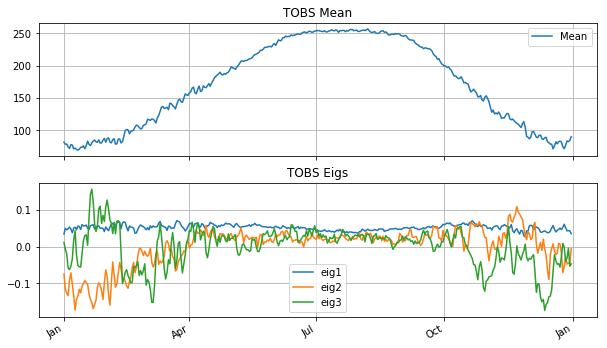

In [6]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [7]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

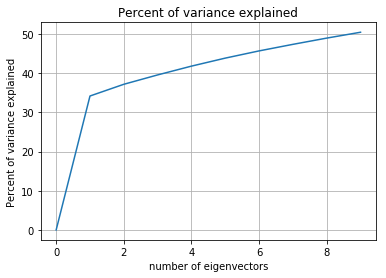

In [8]:
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

In [9]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)

In [11]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1303
after filter 1303


In [12]:
df3=df3.sort(df3.res_3,ascending=True)

In [13]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None

In [14]:
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
# df4 = df3.sort(df3.coeff_2)
rows=df4.take(12)
df4.select('coeff_2','res_2').show(4)

+------------------+-------------------+
|           coeff_2|              res_2|
+------------------+-------------------+
|-613.9384083090775|0.09541899291114692|
| -603.202702581721|0.09495805565007583|
|-596.0424927369053|0.04602514965890328|
|-565.2661843528268|0.07812827940490298|
+------------------+-------------------+
only showing top 4 rows



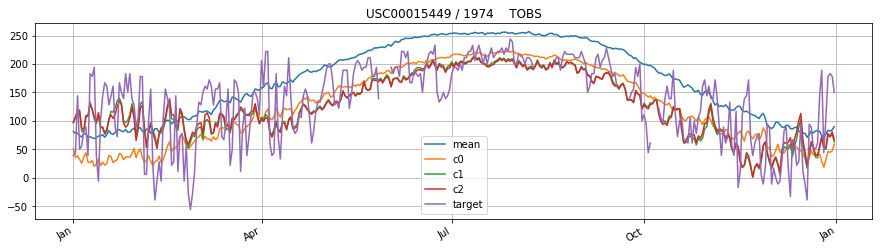

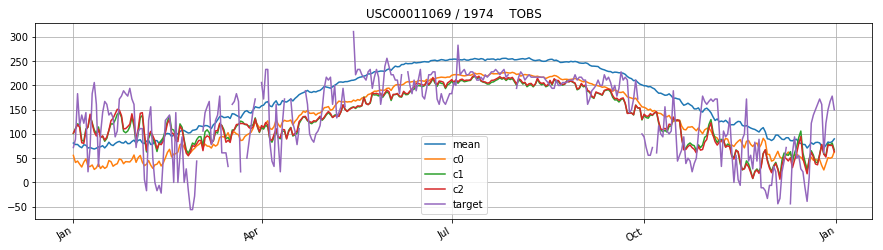

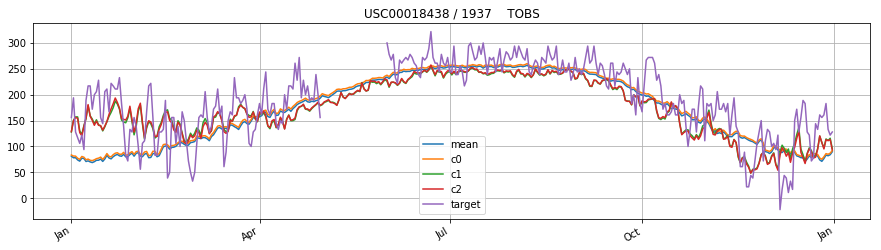

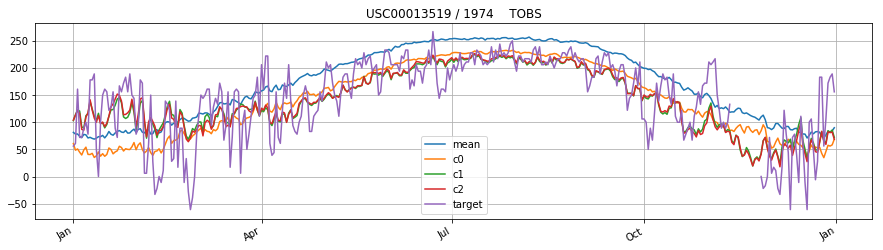

<recon_plot.recon_plot instance at 0x000000000DA3AC08>

In [16]:
fig, axes=plt.subplots(1, 1, sharex='col', sharey='row',figsize=(15,4))
plot_decomp(rows[0],Mean,v,fig=fig,ax=axes,interactive=False)
fig, axes=plt.subplots(1, 1, sharex='col', sharey='row',figsize=(15,4))
plot_decomp(rows[1],Mean,v,fig=fig,ax=axes,interactive=False)
fig, axes=plt.subplots(1, 1, sharex='col', sharey='row',figsize=(15,4))
plot_decomp(rows[2],Mean,v,fig=fig,ax=axes,interactive=False)
fig, axes=plt.subplots(1, 1, sharex='col', sharey='row',figsize=(15,4))
plot_decomp(rows[3],Mean,v,fig=fig,ax=axes,interactive=False)

In [ ]:
# plot_recon_grid(rows)

In [17]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(12)
df5.select('coeff_2','res_2').show(4)

+------------------+--------------------+
|           coeff_2|               res_2|
+------------------+--------------------+
| 678.4390154791226|0.033015573193918984|
| 583.0510109137964| 0.04737693750228704|
| 569.3008560220046|0.060306907766926904|
|505.86105958335526| 0.05385107442920294|
+------------------+--------------------+
only showing top 4 rows



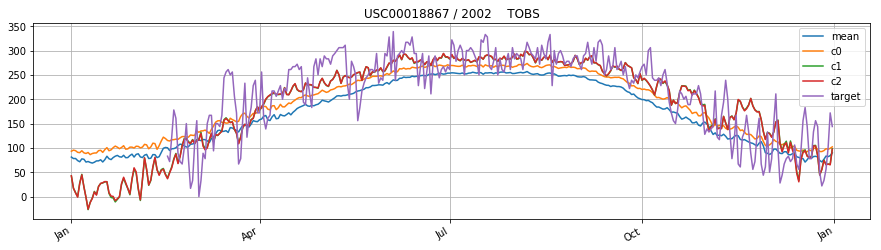

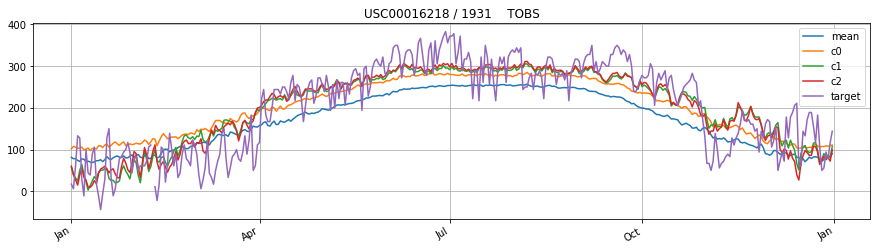

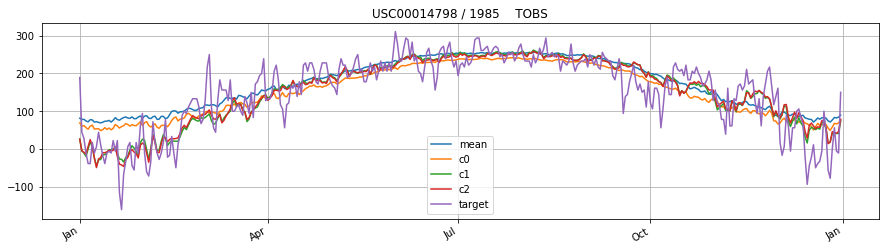

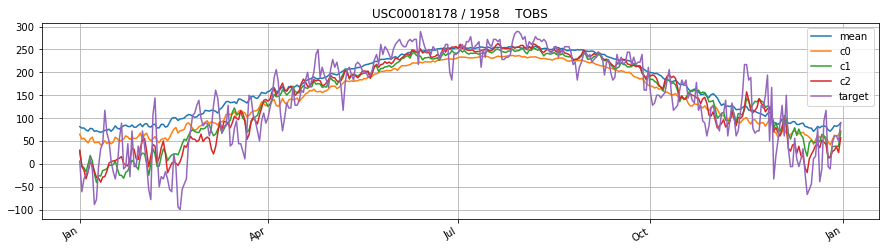

<recon_plot.recon_plot instance at 0x000000000CFF2048>

In [18]:
# plot_recon_grid(rows)
fig, axes=plt.subplots(1, 1, sharex='col', sharey='row',figsize=(15,4))
plot_decomp(rows[0],Mean,v,fig=fig,ax=axes,interactive=False)
fig, axes=plt.subplots(1, 1, sharex='col', sharey='row',figsize=(15,4))
plot_decomp(rows[1],Mean,v,fig=fig,ax=axes,interactive=False)
fig, axes=plt.subplots(1, 1, sharex='col', sharey='row',figsize=(15,4))
plot_decomp(rows[2],Mean,v,fig=fig,ax=axes,interactive=False)
fig, axes=plt.subplots(1, 1, sharex='col', sharey='row',figsize=(15,4))
plot_decomp(rows[3],Mean,v,fig=fig,ax=axes,interactive=False)

residual normalized norm  after mean: 0.0529030687001
residual normalized norm  after mean + top eigs: [ 0.03666827  0.03301557  0.03293147]


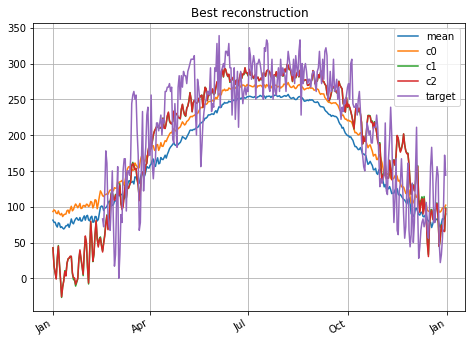

In [19]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

In [20]:
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

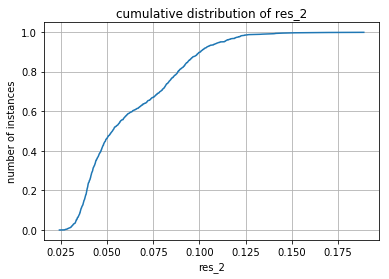

In [21]:
plot_CDF('res_2')

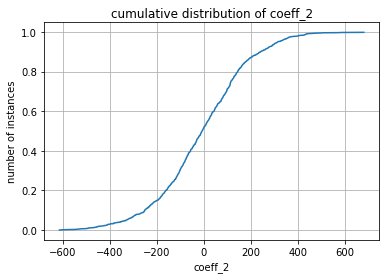

In [22]:
plot_CDF('coeff_2')

In [ ]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)